<a href="https://colab.research.google.com/github/LuFernandez/PASA/blob/master/TP1.%20Laboratorio%20de%20estimaci%C3%B3n%20no-param%C3%A9trica/Informe/Ejercicio1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 1



## Preparativos
Debe guardarse el archivo readligo.py en el directorio correspondiente para poder leer los datos correctamente.

### Clonamos el repositorio de Github

In [42]:
#https://medium.com/@navan0/how-to-push-files-into-github-from-google-colab-379fd0077aa8
!git clone https://github.com/LuFernandez/PASA.git

fatal: destination path 'PASA' already exists and is not an empty directory.


In [43]:
!git init
!git config -- global user.email “togonzalez@itba.edu.ar”
!git config -- global user.name “taomasgonzalez”

Reinitialized existing Git repository in /content/.git/
error: key does not contain a section: global
error: key does not contain a section: global


### Imports necesarios a lo largo del ejercicio

In [0]:
import h5py as h5
from scipy import signal as scsig
import numpy as np
import matplotlib.pyplot as plt
import readligo as rl
from scipy import fftpack as scfft

## Lectura de datos

In [0]:
def read_data(path, name):
  strain, time, chan_dict = rl.loaddata(path, name)
  dt = time[1] - time[0]
  times = dt*np.array([i for i in range(len(strain))])
  return (strain, times, chan_dict)

fs = 4096
folder_path = "PASA/TP1. Laboratorio de estimación no-paramétrica/LIGO/"
# leemos los datos de Livingston
strain_l1, times_l1, chan_dict_l1 = read_data(path=folder_path+'L-L1_LOSC_4_V2-1126259446-32.hdf5', name='L1')

# leemos los datos de Hanford
strain_h1, time_h1, chan_dict_h1 = read_data(path=folder_path+'H-H1_LOSC_4_V2-1126259446-32.hdf5', name='H1')


## Visualización de datos

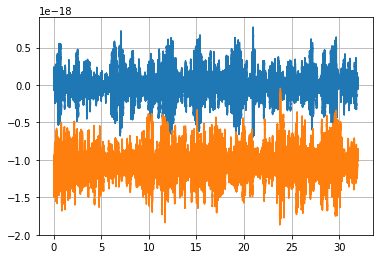

In [46]:
plt.plot(times_l1, strain_h1)
plt.plot(time_h1, strain_l1)
plt.grid()
plt.show()

## a) Estimación del espectro de potencia del ruido mediante el uso de periodogramas

### Implementación del periodograma

In [0]:
def periodogram(fs, data, figure_number, x_lim, title, plot=True):
  # cantidad de muestras
  N = len(data)
  z = scfft.fft(x=data, n=N)
  R = z*np.conj(z)
  freqs = np.fft.fftfreq(N)
  xf = np.linspace(0, fs/2, N//2)    #frecuencias
  if plot:
    plt.loglog(xf, 2/N * np.abs(R[:N//2]))
    plt.loglog(xf, 2/N * np.abs(R[:N//2]))
    plt.xlim(x_lim)
    plt.grid()
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density Rx(f)")
    plt.show()
  
  return (freqs, R)

### Aplicado a Livingston
Hacemos el periodograma para los datos de Levingston en su totalidad, y divididimos en secotres para calcular el error y corroborar estacionariedad.

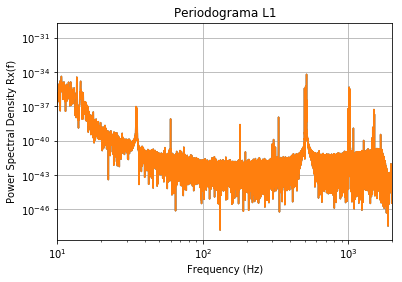

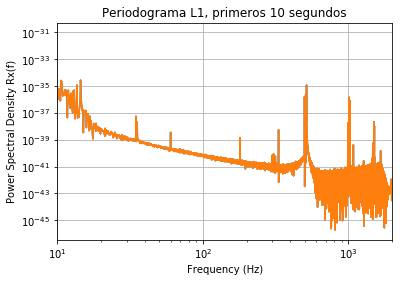

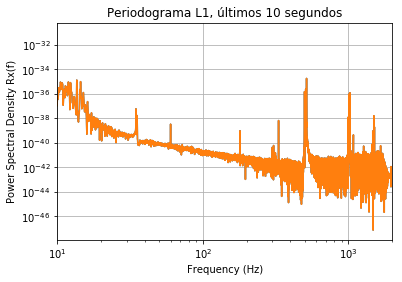

In [48]:
f_l1, Pxx_l1 = periodogram(fs=fs, data=strain_l1, figure_number=1, x_lim=(10, 2000), title="Periodograma L1")
f_l1, Pxx_l1 = periodogram(fs=fs, data=strain_l1[:len(strain_l1)//3], figure_number=1, x_lim=(10, 2000), title="Periodograma L1, primeros 10 segundos")
f_l1, Pxx_l1 = periodogram(fs=fs, data=strain_l1[int(len(strain_l1)*2/3):], figure_number=1, x_lim=(10, 2000), title="Periodograma L1, últimos 10 segundos")


### Aplicado a Hanford
Hacemos el periodograma para los datos de Hanford en su totalidad, y divididimos en secotres para calcular el error y corroborar estacionariedad.

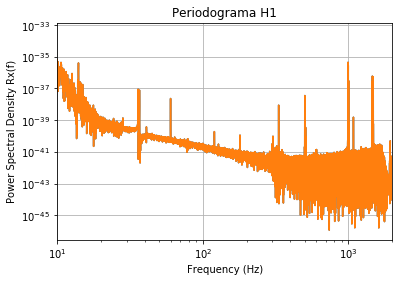

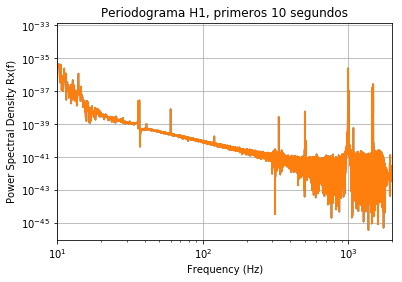

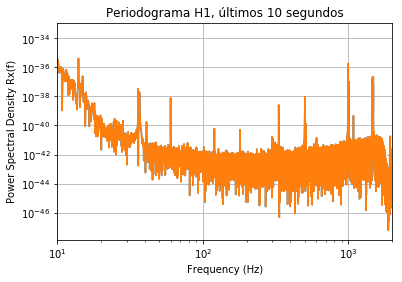

In [49]:
f_h1, Pxx_h1 = periodogram(fs=fs, data=strain_h1, figure_number=1, x_lim=(10, 2000), title="Periodograma H1")
f_h1, Pxx_h1 = periodogram(fs=fs, data=strain_h1[:len(strain_h1)//3], figure_number=2, x_lim=(10, 2000), title="Periodograma H1, primeros 10 segundos")
f_h1, Pxx_h1 = periodogram(fs=fs, data=strain_h1[int(len(strain_l1)*2/3):], figure_number=3, x_lim=(10, 2000), title="Periodograma H1, últimos 10 segundos")

## b) Estimación del espectro de potencia del ruido mediante el uso del método de Blackman-Tukey

### Implementación del método de Blackman-Tukey

Definimos como crear la ventana necesaria:

In [0]:
def create_b_tukey_window(M, L):
    #creamos la ventana
  delta_w = 2*np.pi/ ( N * (2*M+1) )
  window = np.sin(delta_w / 2 / np.array([l for l in range(1,L+1)]))                 
  window = np.append( np.flip(window), np.append([1] , window) )
  return window

Definimos como estimar la autocorrelación de una señal ruidosa:

In [0]:
def autocorrelation_estimation(data, L):
  N = len(data)
  # estimamos la autocorrelacion en el punto l con la fórmula
  # r_x(l) = 1/N * sum(x(n+l)*conj(x(n)), 0, N-l-1)
  # Formamos el vector r_x con todos l de 0 a L 
  r_x = np.array([np.sum([data[j+l]*np.conj(data[j])/N for j in range(0, N-l)]) for l in range(L+1)])
  
  # terminamos de completar r_x con los valores de -L a -1:
  r_x = np.append( np.flip( [ np.conj(r_x[i]) for i in range(1, len(r_x)) ] ) , r_x )
  
  return r_x

Finalmente, implementamos el método:

In [0]:
#frac_N_l = N/l
def blackman_tukey(fs, data, figure_number, x_lim, title, M, frac_N_l=5):
  # cantidad de muestras N
  # Se recomienda N mayor a 50, y |l| ≤ N/4 (Box & Jenkins, 1976). 
  L = len(data)//frac_N_l
  N = len(data)
  if N <= 50:
    print('Se recomienda elegir una cantidad de muestras mayor a 50! (Box & Jenkins, 1976)')
  if L > N//4:
    print('Se recomienda elegir |l|<=N/4! (Box & Jenkins, 1976)')
    
  r_xw = autocorrelation_estimation(data, L) * create_b_tukey_window(M, L)
  print(r_xw)
  
  z = scfft.fft(x=r_xw, n=len(r_xw))
  freqs = np.fft.fftfreq(len(r_xw))
  
  #realizamos el plot
  plt.loglog(xf, 2/N * np.abs(R[:N//2]))
  plt.xlim(x_lim)
  plt.grid()
  plt.title(title)
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Power Spectral Density Rx(f)")
  plt.show()
  return (freqs, R)

### Aplicado a los datos de Livingston

In [61]:
blackman_tukey(fs=fs, data=strain_l1, figure_number=1, x_lim=(10,2000), title='Strain L1', M=20, frac_N_l=5)
blackman_tukey(fs=fs, data=strain_l1, figure_number=1, x_lim=(10,2000), title='Strain L1', M=20, frac_N_l=5)
blackman_tukey(fs=fs, data=strain_l1, figure_number=1, x_lim=(10,2000), title='Strain L1', M=20, frac_N_l=5)

KeyboardInterrupt: ignored

### Aplicado a los datos de Hanford

In [0]:
blackman_tukey(fs=fs, data=strain_h1, figure_number=2, (10,2000), 'Strain H1', M=20, frac_N_l=5)
blackman_tukey(fs=fs, data=strain_h1, figure_number=2, (10,2000), 'Strain H1', M=20, frac_N_l=5)
blackman_tukey(fs=fs, data=strain_h1, figure_number=2, (10,2000), 'Strain H1', M=20, frac_N_l=5)

## c) Estimación del espectro de potencia del ruido mediante el uso del método de Welch-Barlett

### Implementación del método de Welch-Barlett

In [0]:
#Inspirado en https://stackoverflow.com/questions/46882312/python-implementation-of-bartlett-periodogram

#nperseg : L
def welch_barlett(data, fs,  D, nperseg=512, nfft=512, title='',x_lim=(10,2000), plot=True):
    def cropping(init):
        if init < 0:
            return 0
        else:
            return init
    R = np.array([np.fft.fft(a=data[cropping(-nperseg+i*D):  nperseg+i*D], n=nperseg)
                  for i in range(len(data)//nperseg)])
    abs_R = np.sum(np.abs(R)**2, axis=0)
    freqs = np.fft.fftfreq(n=nperseg, d=1/fs)

    if plot: 
      plt.loglog(freqs, 2/nperseg * abs_R)
      plt.loglog(freqs, 2/nperseg * abs_R)
      plt.xlim(x_lim)
      plt.grid()
      plt.title(title)
      plt.xlabel("Frequency (Hz)")
      plt.ylabel("Power Spectral Density Rx(f)")
      plt.show()
    return freqs, R    

### Aplicado a los datos de Livingston

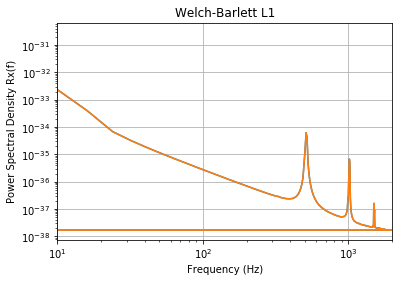

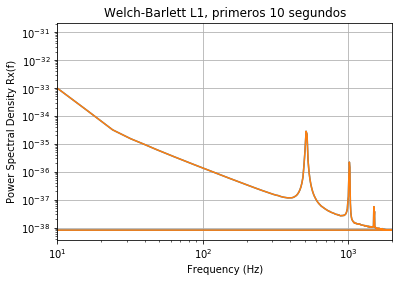

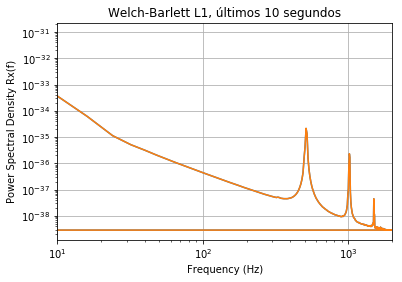

In [95]:
f, R = welch_barlett(data=strain_l1, fs=fs,  D=100, nperseg=512, nfft=512, title='Welch-Barlett L1',x_lim=(10,2000), plot=True)
f, R = welch_barlett(data=strain_l1[:len(strain_l1)//3], fs=fs,  D=100, nperseg=512, nfft=512, title='Welch-Barlett L1, primeros 10 segundos',x_lim=(10,2000), plot=True)
f, R = welch_barlett(data=strain_l1[int(len(strain_l1)*(2/3)):], fs=fs,  D=100, nperseg=512, nfft=512, title='Welch-Barlett L1, últimos 10 segundos',x_lim=(10,2000), plot=True)

### Aplicado a los datos de Hanford

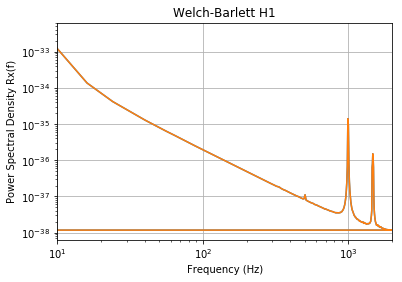

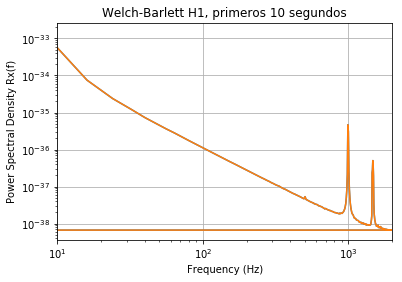

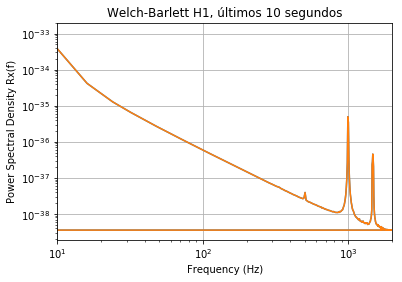

In [96]:
f, R = welch_barlett(data=strain_h1, fs=fs,  D=100, nperseg=512, nfft=512, title='Welch-Barlett H1',x_lim=(10,2000), plot=True)
f, R = welch_barlett(data=strain_h1[:len(strain_h1)//3], fs=fs,  D=100, nperseg=512, nfft=512, title='Welch-Barlett H1, primeros 10 segundos',x_lim=(10,2000), plot=True)
f, R = welch_barlett(data=strain_h1[int(len(strain_h1)*(2/3)):], fs=fs,  D=100, nperseg=512, nfft=512, title='Welch-Barlett H1, últimos 10 segundos',x_lim=(10,2000), plot=True)

## d) Estimación del espectro de potencia del ruido mediante el uso del enfoque multitaper con funciones DPSS

### Implementación del método multitaper con funciones DPSS

In [0]:
# para la matemática:
# https://ccrma.stanford.edu/~jos/sasp/Slepian_DPSS_Window.html
# para las ventanas:
# https://scipy.github.io/devdocs/generated/scipy.signal.windows.dpss.html
# sym bool, optional
#When True (default), generates a symmetric window, for use in filter design. When False, generates a periodic window, for use in spectral analysis.
def multitaper_dpss(data, fs, n_windows, x_lim=(10,2000), title='', plot=True):
  # tomo a x_lim[1] como el bandwith!!!
  sequences = scsig.windows.dpss(M=len(data), NW=x_lim[1]/(2*fs), Kmax=n_windows, sym=False)
  R_i = abs( np.fft.fft( a=np.multiply(data,sequences) ) ) ** 2 / len(data)
  freqs = np.fft.fftfreq( n=len(data), d=1/fs )
  R = np.sum(R_i, axis=0) / n_windows
  if plot: 
    plt.loglog(freqs, 2/len(data) * R)
    plt.loglog(freqs, 2/len(data)  * R)
    plt.xlim(x_lim)
    plt.grid()
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density Rx(f)")
    plt.show()
  #return freqs, R

## Aplicado a los datos de Livingston

In [3]:
multitaper_dpss(data=strain_l1, fs=fs, n_windows=100, x_lim=(10,2000), title='Multitaper L1', plot=True)
multitaper_dpss(data=strain_l1, fs=fs, n_windows=100, x_lim=(10,2000), title='Multitaper L1, primeros 10 segundos', plot=True)
multitaper_dpss(data=strain_l1, fs=fs, n_windows=100, x_lim=(10,2000), title='Multitaper L1, últimos 10 segundos', plot=True)

NameError: ignored

## Aplicado a los datos de Hanford

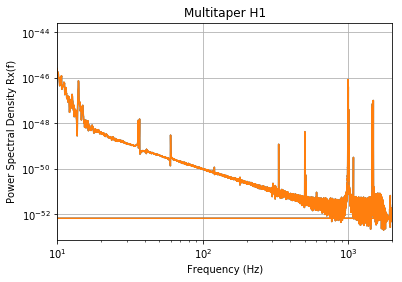

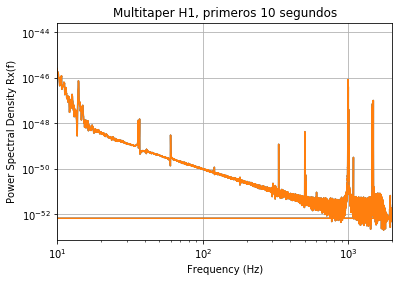

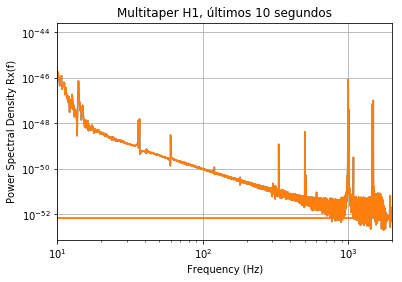

In [114]:
multitaper_dpss(data=strain_h1, fs=fs, n_windows=100, x_lim=(10,2000), title='Multitaper H1', plot=True)
multitaper_dpss(data=strain_h1, fs=fs, n_windows=100, x_lim=(10,2000), title='Multitaper H1, primeros 10 segundos', plot=True)
multitaper_dpss(data=strain_h1, fs=fs, n_windows=100, x_lim=(10,2000), title='Multitaper H1, últimos 10 segundos', plot=True)

#Ejercicio 2

## Inversa del espectro de potencia del ruido


### Implementación el filtro inversor

In [0]:
def inverse_spectogram(data):
  return np.array([1/d for d in data])

Utilización del filtro inversor en la señal

## Visualización en frecuencia del resultado

### Livingston

### Hanford

## Visualización en tiempo del resultado

### Hanford

### Livingston